In [47]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [48]:
transcript = pd.read_csv('transcripts/transcripts.csv', delimiter='|')
qna =  pd.read_csv('transcripts/QnA.csv', delimiter='|')

# Merge the two dataframes
df = pd.merge(transcript, qna[['transcript','filename']], on='filename')

# rename transcript_x to presentation and transcript_y to QnA
df = df.rename(columns={'transcript_x': 'presentation', 'transcript_y': 'QnA'})

mapping = pd.read_csv('data/mapping.csv')

# create a new column 'AllNames' that concatenates all versions of 'Company' for a 'CompanyName'
mapping['AllNames'] = mapping.groupby('RR_CompanyName')['Transcript_Mapping'].transform(lambda x: ', '.join(x))
mapping.head()

# Load recovery rates
rr = pd.read_csv('data/RR_Bonds.csv')
rr = rr[['Ddate', 'RR', 'CompanyName', 'CUSIP', 'LTDIssuance2', 'Intangibility', 'Receivables1']]

preprocessed_df = pd.read_csv('data/preprocessed_bond_data.csv')

# Add rr columns to preprocessed_df on index
preprocessed_df['RR'] = rr['RR']
preprocessed_df['Ddate'] = rr['Ddate']
preprocessed_df['CompanyName'] = rr['CompanyName']
preprocessed_df['CUSIP'] = rr['CUSIP']
preprocessed_df['LTDIssuance2'] = rr['LTDIssuance2']
preprocessed_df['Intangibility'] = rr['Intangibility']
preprocessed_df['Receivables1'] = rr['Receivables1']

rr = preprocessed_df

# Convert 'Date' column to datetime
rr['Ddate'] = pd.to_datetime(rr['Ddate'], errors='coerce')
rr.head()

# merge rr with mapping on CompanyName and RR_CompanyName
rr = rr.merge(mapping, left_on='CompanyName', right_on='RR_CompanyName')

# join with df on Company and Transcripts_Mapping
merged_df = rr.merge(df, left_on='Transcript_Mapping', right_on='Company')
print(merged_df['CompanyName'].value_counts())

# Ensure the columns are in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Ddate'] = pd.to_datetime(merged_df['Ddate'])

# Compute the difference in days
merged_df['diff'] = (merged_df['Ddate'] - merged_df['Date']).dt.days

merged_df = merged_df[merged_df['Ddate']>merged_df['Date']]
merged_df = merged_df.sort_values(by='Date').groupby(['CUSIP']).tail(1)

print(merged_df['CompanyName'].value_counts())

Ally Financial Inc.               10317
CIT Group Inc.                    10185
Lehman Brothers Holdings, Inc.     2853
Charter Communications, Inc.       2144
Sempra Energy                      1147
                                  ...  
Frontier Group Holdings, Inc.         1
Dayton Superior Corporation           1
Franklin Bank Corp.                   1
Kellwood Company, LLC                 1
Turning Point Brands, Inc.            1
Name: CompanyName, Length: 210, dtype: int64
Lehman Brothers Holdings, Inc.      317
CIT Group Inc.                      291
Charter Communications, Inc.         28
Ford Motor Company                   19
iStar Inc.                           17
                                   ... 
Centrus Energy Corp.                  1
Education Management Corporation      1
Venoco, Inc.                          1
Exelon Corporation                    1
Kellwood Company, LLC                 1
Name: CompanyName, Length: 159, dtype: int64


In [57]:
df = merged_df.copy()

# count unique transcripts in transcripts['Cleaned_Bankruptcy_Indicators']
print(df['presentation'].nunique())

# add a number to each transcript based on the 196 unique transcripts
df['transcript_number'] = df['presentation'].factorize()[0]

number_transcript = df[['transcript_number', 'presentation']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

196


,transcript_number,presentation
27094,0,Presentation\nOperator\nGood morning Ladies an...
22380,1,"Presentation\nOperator\nLadies and gentlemen, ..."
5878,2,Presentation\nOperator\nGreetings ladies and g...
6097,3,"Presentation\nOperator\nThank you, all parties..."
6417,4,Presentation\nOperator\nThank you for joining ...


In [61]:
emotion_scores = pd.read_csv('goemotions/emotion_scores_summary.csv')
group_emotion_scores = pd.read_csv('goemotions/group_emotion_scores_summary.csv')

emotion_scores.drop(columns=['Unnamed: 0'], inplace=True)
group_emotion_scores.drop(columns=['Unnamed: 0'], inplace=True)

emotion_scores = emotion_scores.merge(group_emotion_scores, on='transcript_number')

# merge emotion_scores with df on emotion_scores['transcript_number'] == df['transcript_number']
emotion_scores = emotion_scores.merge(df, on='transcript_number')

In [62]:
emotions = [
        #'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        #'approval', 
        #'caring', 
        'confusion', 
        #'curiosity', 
        'desire', 
        #'disappointment', 
        #'disapproval', 
        #'disgust', 
        #'embarrassment', 
        'excitement', 
        'fear', 
        'gratitude', 
        #'grief', 
        #'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        #'realization', 
        #'relief', 
        #'remorse', 
        #'sadness', 
        #'surprise',
        ## Group emotions
        'positive', 'negative', 'ambiguous'
    ]

In [63]:
# normalize all emotions
for emotion in emotions:
    emotion_scores[emotion] = (emotion_scores[emotion] - emotion_scores[emotion].mean()) / emotion_scores[emotion].std()

In [72]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

# Select the supporting features, nlp_lables, and RR from final_df
final_df = emotion_scores[['RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + emotions
                    ]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

final_df.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,RR,anger,annoyance,confusion,desire,excitement,fear,gratitude,nervousness,optimism,pride,positive,negative,ambiguous
0,29.023972,0.0,-0.12536,-0.115608,-0.161674,-0.0305,-0.042832,-0.131839,-0.096166,-1.642699,-0.10163,-1.197802,-1.224582,-0.130108
1,8.869420,0.0,-0.12536,-0.115608,-0.161674,-0.0305,-0.042832,-0.131839,-0.096166,4.512012,-0.10163,1.682222,0.742355,-0.130108
2,33.210455,0.0,-0.12536,-0.115608,-0.161674,-0.0305,-0.042832,-0.131839,-0.096166,0.868399,-0.10163,1.655471,-1.224582,-0.130108
3,11.875000,0.0,-0.12536,-0.115608,-0.161674,-0.0305,-0.042832,-0.131839,-0.096166,-1.642699,-0.10163,-1.197802,-1.224582,-0.130108
4,18.340000,0.0,-0.12536,-0.115608,-0.161674,-0.0305,-0.042832,-0.131839,-0.096166,-0.023094,-0.10163,-0.706456,0.113504,-0.130108


In [73]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     59.77
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          5.73e-218
Time:                        14:51:35   Log-Likelihood:                -4439.5
No. Observations:                1075   AIC:                             8949.
Df Residuals:                    1040   BIC:                             9123.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

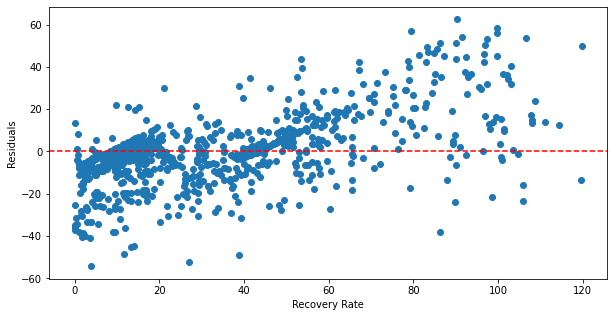

In [66]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [67]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3173.197422
17                                Financials    15.176972
11                      ActIndustryDistress1     8.107305
4         30 year conventional mortgage rate     6.893738
3   Manufacturers inventories to sales ratio     6.808686
12                      ActIndustryDistress2     4.928914
18                                    Energy     4.819759
2                    NASDAQ 100 Index return     4.765003
6                     Consumer Discretionary     4.424286
1                 CBOE DJIA Volatility Index     4.088488
5                     Communication Services     3.262228
33                                  positive     3.153910
34                                  negative     2.956845
20                                 Utilities     2.262496
21                    Information Technology     2.155522
9                               Equity value     2.131273
16            

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     60.88
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          2.08e-234
Time:                        14:51:49   Log-Likelihood:                -4391.0
No. Observations:                1075   AIC:                             8860.
Df Residuals:                    1036   BIC:                             9054.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

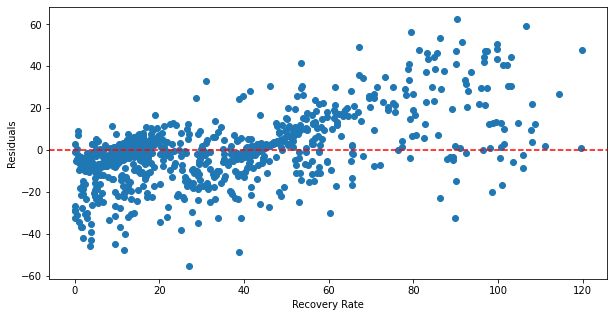

In [70]:
# Bond data 2 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [71]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3258.579630
17                                Financials    15.493929
11                      ActIndustryDistress1     8.587903
4         30 year conventional mortgage rate     7.121762
3   Manufacturers inventories to sales ratio     6.956554
2                    NASDAQ 100 Index return     5.378461
18                                    Energy     5.047865
12                      ActIndustryDistress2     4.960789
6                     Consumer Discretionary     4.530589
1                 CBOE DJIA Volatility Index     4.162104
5                     Communication Services     3.531328
37                                  positive     3.286819
38                                  negative     3.079850
9                               Equity value     2.384002
24                              LTDIssuance2     2.375689
20                                 Utilities     2.287734
21            

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     12.73
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           1.26e-24
Time:                        14:52:15   Log-Likelihood:                -4949.5
No. Observations:                1075   AIC:                             9925.
Df Residuals:                    1062   BIC:                             9990.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          34.2709      0.742     46.199      

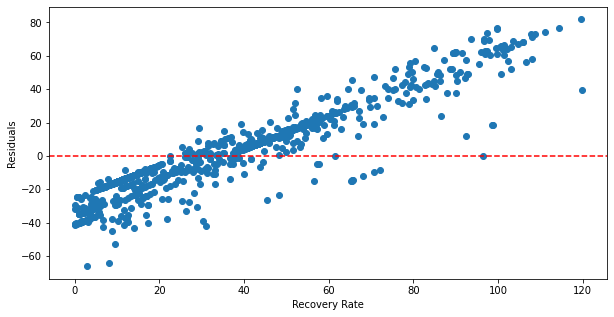

In [74]:
# Emotions

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [75]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

       Features       VIF
11     positive  1.431009
12     negative  1.390233
9      optimism  1.160498
4        desire  1.096021
2     annoyance  1.080294
3     confusion  1.075238
13    ambiguous  1.072751
7     gratitude  1.069737
8   nervousness  1.043202
10        pride  1.022168
5    excitement  1.013343
6          fear  1.012834
0         const  1.000000
1         anger       NaN


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
